<a href="https://colab.research.google.com/github/hhduke2014/marked-beetle-analysis/blob/main/efficientnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import glob
import shutil
import json
import keras
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from keras.preprocessing.image import ImageDataGenerator

import cv2
from sklearn.model_selection import train_test_split

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
filenames = os.listdir("/content/drive/MyDrive/MarkedBeetleImageAnalysis")
filenames[:4]


['PaperedControl20v_light.tif',
 'PaperedControl20d.tif',
 'PaperedControl20d_light.tif',
 'PaperedControl21v.tif']

In [3]:
train_images=[]
for filename in filenames:
    if filename.startswith('Papered') or filename.startswith('NoPapered'):
        train_images.append(filename)
print(f"Number of Train images: {len(train_images)}") #filename.startswith('Pink')

Number of Train images: 801


In [4]:
test_images=[]
for filename in filenames:
    if filename.startswith('Trap'):
        test_images.append(filename)
print(f"Number of Test images: {len(test_images)}")

Number of Test images: 77


In [5]:
categories = []
for filename in train_images:
    if filename.startswith('Papered') or filename.startswith('Pink') or filename.startswith('Trap'):
        categories.append('Marked')
    if filename.startswith('NoPapered'):
        categories.append('NotMarked')
len(categories)

801

In [6]:

df = pd.DataFrame({
    'filename': train_images,
    'category': categories
})
df

,filename,category
0,PaperedControl20v_light.tif,Marked
1,PaperedControl20d.tif,Marked
2,PaperedControl20d_light.tif,Marked
3,PaperedControl21v.tif,Marked
4,PaperedControl21v_light.tif,Marked
...,...,...
796,PaperedControl18v.tif,Marked
797,PaperedControl18d.tif,Marked
798,PaperedControl19v.tif,Marked
799,PaperedControl19d.tif,Marked


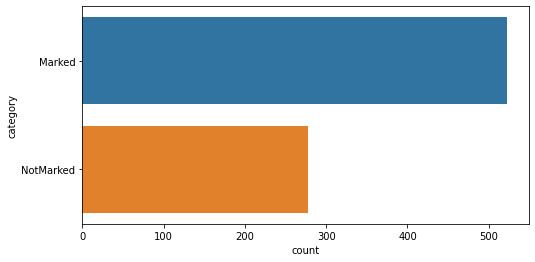

In [7]:
plt.figure(figsize=(8, 4))
sns.countplot(y="category", data=df);

In [11]:
image = cv2.imread(os.path.join("/content/drive/MyDrive/MarkedBeetleImageAnalysis", filenames[0]))
image.shape

(1944, 2592, 3)

In [12]:
def visualize_batch(image_ids, labels):
    plt.figure(figsize=(16, 12))
    for ind, (image_id, label) in enumerate(zip(image_ids, labels)):
        plt.subplot(3, 3, ind+1 )
        image = cv2.imread(os.path.join("/content/drive/MyDrive/MarkedBeetleImageAnalysis", image_id))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.imshow(image)
        plt.title(f"{label}", fontsize=12)
        plt.axis("off")
    
    plt.show()

In [13]:
tmp_df = df.sample(9)
tmp_df

,filename,category
387,NoPaperedGreen15v.tif,NotMarked
39,PaperedControl34d_light.tif,Marked
622,NoPaperedMixed48d.tif,NotMarked
693,PaperedMixed34v.tif,Marked
81,PaperedControl52d.tif,Marked
113,PaperedControl66v.tif,Marked
731,NoPaperedMixed3d.tif,NotMarked
744,PaperedControl4v.tif,Marked
528,NoPaperedGreen86d.tif,NotMarked


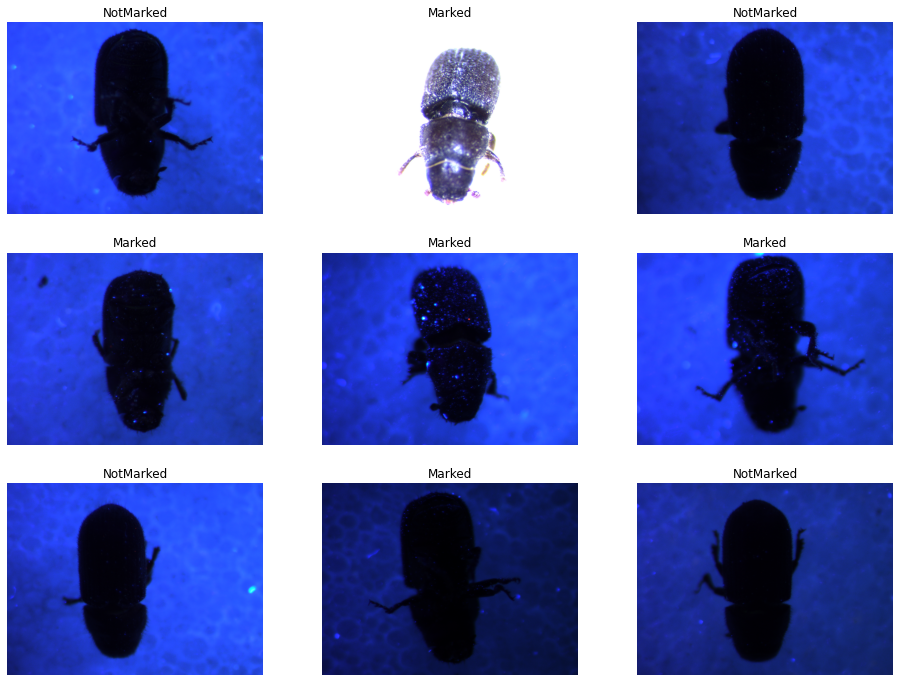

In [14]:
image_ids = tmp_df["filename"].values
labels = tmp_df["category"].values

visualize_batch(image_ids, labels)

In [26]:
df["category"] = df["category"].replace({0: 'NotMarked', 1: 'Marked'}) 

In [27]:
train_df, validate_df = train_test_split(df, test_size = 0.10, random_state = 42, stratify = df['category'])
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

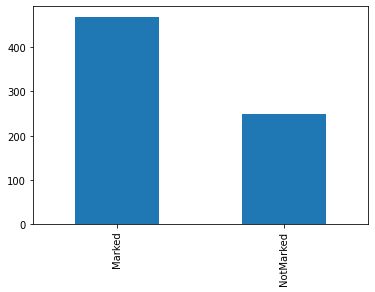

In [28]:
train_df['category'].value_counts().plot.bar()

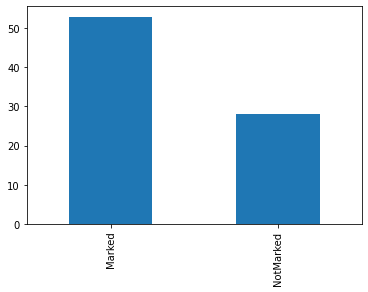

In [29]:
validate_df['category'].value_counts().plot.bar()

In [30]:
IMG_SIZE = 456
size = (IMG_SIZE,IMG_SIZE)
n_CLASS = 2
BATCH_SIZE = 15

In [31]:
datagen_train = ImageDataGenerator(
                    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                    rotation_range = 40,
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    shear_range = 0.2,
                    zoom_range = 0.2,
                    horizontal_flip = True,
                    vertical_flip = True,
                    fill_mode = 'nearest')

In [32]:
datagen_val = ImageDataGenerator(
                    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                    )

In [33]:
train_set = datagen_train.flow_from_dataframe(train_df,
                             directory = "/content/drive/MyDrive/MarkedBeetleImageAnalysis",
                             seed=42,
                             x_col = 'filename',
                             y_col = 'category',
                             target_size = size,
                             #color_mode="rgb",
                             class_mode = 'categorical',
                             interpolation = 'nearest',
                             shuffle = True,
                             batch_size = BATCH_SIZE)

Found 720 validated image filenames belonging to 2 classes.


In [34]:
validate_set = datagen_val.flow_from_dataframe(validate_df,
                             directory = "/content/drive/MyDrive/MarkedBeetleImageAnalysis",
                             seed=42,
                             x_col = 'filename',
                             y_col = 'category',
                             target_size = size,
                             #color_mode="rgb",
                             class_mode = 'categorical',
                             interpolation = 'nearest',
                             shuffle = True,
                             batch_size = BATCH_SIZE)

Found 81 validated image filenames belonging to 2 classes.


In [42]:
# MODEL CREATION 

from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB3

def create_model():
    
    model = Sequential()
    # initialize the model with input shape
    model.add(EfficientNetB3(input_shape = (IMG_SIZE, IMG_SIZE, 3), include_top = False,
                             weights = 'imagenet',
                             drop_connect_rate=0.6))
    #for layer in model.layers[:-40]:  # Training just part of the architecture do not optimize the performance
    #    layer.trainable = False
    model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu', bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(n_CLASS, activation = 'softmax'))
    
    return model

leaf_model = create_model()
leaf_model.summary()

ValueError: ignored

In [36]:
EPOCHS = 1
STEP_SIZE_TRAIN = train_set.n//train_set.batch_size
STEP_SIZE_VALID = validate_set.n//validate_set.batch_size

In [37]:
def Model_fit():
    
    #leaf_model = None
    
    model = create_model()
    
    '''Compiling the model'''
    
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits = False,
                                                   label_smoothing=0.0001,
                                                   name='categorical_crossentropy' )
    
    model.compile(optimizer = Adam(learning_rate = 1e-3),
                        loss = loss, #'categorical_crossentropy'
                        metrics = ['categorical_accuracy']) #'acc'
    
        # Stop training when the val_loss has stopped decreasing for 3 epochs.
    stop = EarlyStopping(monitor='val_loss', mode='min', patience=3,
                       restore_best_weights=True, verbose=1)
    
    # Save the model with the minimum validation loss
    checkpoint_cb = ModelCheckpoint("best_model.h5",
                                    save_best_only=True,
                                    monitor = 'val_loss',
                                    mode='min')
    
    # reduce learning rate
    reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                                  factor = 0.2,
                                  patience = 2,
                                  min_lr = 1e-6,
                                  mode = 'min',
                                  verbose = 1)
    history = model.fit(train_set,
                             validation_data = validate_set,
                             epochs= EPOCHS,
                             batch_size = BATCH_SIZE,
                             #class_weight = d_class_weights,
                             steps_per_epoch = STEP_SIZE_TRAIN,
                             validation_steps = STEP_SIZE_VALID,
                             callbacks=[stop, checkpoint_cb, reduce_lr])
    model.save('model'+'.h5')  
    return history

In [38]:
results = Model_fit()

48/48 [==============================] - 1683s 34s/step - loss: 0.5116 - categorical_accuracy: 0.7319 - val_loss: 0.5863 - val_categorical_accuracy: 0.7467


NotImplementedError: ignored

In [ ]:
model.save_weights("model.h5")